In [1]:
#Imports

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Flatten, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
class SyntheticControlNN:
    def __init__(self):
        self.treated_unit = None
        self.control_units = None
        self.pre_split = None
        self.Y1_pre = None
        self.Y0_pre = None
        self.Y1_post = None
        self.Y0_post = None
        self.model = None
        self.Y_synthetic_pre = None
        self.Y_synthetic_post = None
        self.metrics = None
        self.results = None
        self.history = None
        
        # Separate scalers for X (control units) and y (treated unit)
        self.x_scaler = StandardScaler()
        self.y_scaler = StandardScaler()

    def prepare_data(self, path, treated_unit_idx=0, shift_range=0, preselect_donors=True, lookback=3):
        """Prepare data for synthetic control analysis with optional time shifting."""
        df = pd.read_csv(path, header=0, index_col=0, parse_dates=["date"]).sort_values('date').reset_index(drop=True)
        df = df[[col for col in df.columns if col.startswith('netconsumption')]]
        
        self.treated_unit = df.columns[treated_unit_idx]
        original_control_units = [col for col in df.columns if col != self.treated_unit]

        if shift_range > 0:
            # Dictionary to store all series for later concatenation
            all_series = {}
            
            # Add original data first
            all_series[self.treated_unit] = df[self.treated_unit]
            for control_unit in original_control_units:
                all_series[control_unit] = df[control_unit]
                
            # Create shifted versions for control units
            for shift in range(-shift_range, shift_range + 1):
                if shift == 0:  # Skip zero shift as it's already in original data
                    continue
                    
                # Create shifted versions for all control units at once
                for control_unit in original_control_units:
                    key = f"{control_unit}_shift{shift}"
                    all_series[key] = df[control_unit].shift(shift)
            
            # Concatenate all series at once
            shifted_df = pd.concat(all_series, axis=1)
            
            # Drop rows with NaN values from shifting
            shifted_df = shifted_df.dropna()
            
            # Create control units list - only exclude the exact treated unit
            self.control_units = [col for col in shifted_df.columns if col != self.treated_unit]
            
        else:
            shifted_df = df
            self.control_units = original_control_units
        
        # Split into pre and post treatment periods
        split_index = int(len(shifted_df) * self.pre_split)
        pre_treatment = shifted_df.iloc[:split_index].copy()
        post_treatment = shifted_df.iloc[split_index:].copy()
        
        # Prepare matrices
        self.Y1_pre = pre_treatment[self.treated_unit].values
        self.Y0_pre = pre_treatment[self.control_units].values
        self.Y1_post = post_treatment[self.treated_unit].values
        self.Y0_post = post_treatment[self.control_units].values

        
        # L1-based Weight Computation --------------------
        # For L1 solver, shape must be (#donors, T0) => transpose
        Y0_pre_orig = self.Y0_pre  # shape: (T0, #donors)
        self.Y0_pre = Y0_pre_orig.T  # shape: (#donors, T0)

        self.calculate_optimal_weights()  # populates self.weights

        # Restore shape
        self.Y0_pre = Y0_pre_orig  # (T0, #donors)

        # -------------------- 5. (Optional) Donor Pre-Selection --------------------
        if preselect_donors:
            # Keep only donors with weight >= 0.0005
            threshold = 0.0005
            # Indices of donors that pass the threshold
            donor_indices_to_keep = [i for i, w in enumerate(self.weights) if w >= threshold]
            
            # Build a reduced list of control units
            selected_control_units = [self.control_units[i] for i in donor_indices_to_keep]
            
            # If no donors pass threshold, handle gracefully (keep at least one or zero)
            if len(selected_control_units) == 0:
                print("No donors had weight >= 0.0005. Keeping all donors as fallback.")
            else:
                self.control_units = selected_control_units
                print("Selected control units: ", self.control_units)
            
            # Now slice Y0_pre/Y0_post accordingly
            self.Y0_pre = pre_treatment[self.control_units].values
            self.Y0_post = post_treatment[self.control_units].values

        #overwrite self.Y0_pre, self.Y1_pre, etc. with 3D arrays
        self.Y0_pre, self.Y1_pre = self.build_sequences(self.Y0_pre, self.Y1_pre, lookback)
        self.Y0_post, self.Y1_post = self.build_sequences(self.Y0_post, self.Y1_post, lookback)
               
        return self
    
    def calculate_optimal_weights(self):
        
        """Calculate optimal weights using L1 norm minimization."""
        
        T0 = self.Y1_pre.shape[0]
        J = self.Y0_pre.shape[0]
        
        model = gp.Model("Synthetic_Control_L1")
        model.setParam('OutputFlag', 0)
        
        W = model.addVars(J, lb=0.0, name="W")
        e_plus = model.addVars(T0, lb=0.0, name="e_plus")
        e_minus = model.addVars(T0, lb=0.0, name="e_minus")
        
        model.addConstr(gp.quicksum(W[j] for j in range(J)) == 1)
        
        for t in range(T0):
            discrepancy = self.Y1_pre[t] - gp.quicksum(W[j] * self.Y0_pre[j, t] for j in range(J))
            model.addConstr(discrepancy == e_plus[t] - e_minus[t])
        
        obj = gp.quicksum(e_plus[t] + e_minus[t] for t in range(T0))
        model.setObjective(obj, GRB.MINIMIZE)
        model.optimize()
        
        if model.status == GRB.OPTIMAL:
            self.weights = np.array([W[j].X for j in range(J)])
            return self.weights
        raise ValueError("Optimization failed")

    def build_dense_model(self, input_shape, dropout_rate=0.2, learning_rate=0.001):
        """Build neural network model for synthetic control."""
        model = Sequential([
            Input(shape=input_shape), # e.g. (lookback+1, #donors)
            Flatten(), # Flatten to ( (lookback+1) * #donors, )
            Dense(64, activation='relu'),
            Dropout(dropout_rate),
            Dense(1)
        ])
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
        return model

    def build_lstm_model(self, input_shape, dropout_rate=0.2, learning_rate=0.001):
        
        model = Sequential([
            # Here we use input_shape=(1, input_dim) for a single timestep.
            Input(shape=input_shape),
            LSTM(8, activation='relu', return_sequences=False),
            Dropout(dropout_rate),
            Dense(1)
        ])
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
        return model

    def sc_nn_lstm_pipeline(self, epochs=100, batch_size=32, validation_split=0.2, dropout=0.2, learn_r=0.0005):
        """ Execute synthetic control pipeline using an LSTM network. """
        # 1. Build model
        input_shape = (self.Y0_pre.shape[1], self.Y0_pre.shape[2])  # (lookback+1, #donors)
        self.model = self.build_lstm_model(input_shape=input_shape, dropout_rate=dropout, learning_rate=learn_r)

        # EarlyStopping callback
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=0
        )

        # 3. Train model
        self.history = self.model.fit(
            self.Y0_pre,
            self.Y1_pre,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            callbacks=[early_stopping],
            verbose=0
        )

        # 4. Predictions
        self.Y_synthetic_pre = self.model.predict(self.Y0_pre, verbose=0).flatten()
        self.Y_synthetic_post = self.model.predict(self.Y0_post, verbose=0).flatten()
        
        # 5. Store results
        self.store_results()
        return self

    def build_sequences(self, X, y, lookback):
        """
        Build sequences of length (lookback+1) for each time series row in X.
        
        Parameters
        ----------
        X : np.ndarray of shape (T, #donors)
            Time series data for donors (e.g., pre- or post-treatment).
        y : np.ndarray of shape (T, )
            Treated unit's values aligned to X.
        lookback : int
            Number of *past* steps (not counting the current one) to include.

        Returns
        -------
        X_seq : np.ndarray of shape (T - lookback, lookback+1, #donors)
            3D array where each slice X_seq[i] is the block of donor data
            from time (i - lookback) up to and including time i.
        y_seq : np.ndarray of shape (T - lookback, )
            The treated unit's value at each “current” time step i.
        """
        X_seq, y_seq = [], []
        for i in range(lookback, len(X)):
            # from i-lookback to i (inclusive) is (lookback+1) steps
            X_seq.append(X[i - lookback : i + 1, :])
            y_seq.append(y[i])
        return np.array(X_seq), np.array(y_seq)

    def sc_nn_dense_pipeline(self, epochs=100, batch_size=32, validation_split=0.2, dropout=0.2, learn_r=0.001):
        """Execute synthetic control pipeline using neural network."""
        # Build and train model on pre-treatment data
        input_shape = (self.Y0_pre.shape[1], self.Y0_pre.shape[2])  # e.g. (lookback+1, #donors)
        self.model = self.build_dense_model(input_shape=input_shape, dropout_rate=dropout, learning_rate=learn_r)

        # Define early stopping callback
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=0
        )

        self.history = self.model.fit(
            self.Y0_pre,
            self.Y1_pre,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            callbacks=[early_stopping],
            verbose=0
        )

        self.Y_synthetic_pre = self.model.predict(self.Y0_pre, verbose=0).flatten()
        self.Y_synthetic_post = self.model.predict(self.Y0_post, verbose=0).flatten()
        
        self.store_results()
        return self
    
    def store_results(self):
        """ Store the pre- and post-treatment predictions in self.results as a DataFrame."""
        pre_df = pd.DataFrame({
            'period': range(len(self.Y1_pre)),
            'actual': self.Y1_pre,
            'predicted': self.Y_synthetic_pre,
            'phase': 'pre'
        })

        post_df = pd.DataFrame({
            'period': range(len(self.Y1_post)),
            'actual': self.Y1_post,
            'predicted': self.Y_synthetic_post,
            'phase': 'post'
        })

        self.results = pd.concat([pre_df, post_df], ignore_index=True)
        self.results['building'] = self.treated_unit
   
    def calculate_metrics(self):
        """Calculate performance metrics."""
        if self.results is None:
            raise ValueError("Run sc_nn_pipeline first")
            
        post_mask = self.results['phase'] == 'post'
        post_actual = self.results.loc[post_mask, 'actual']
        post_predicted = self.results.loc[post_mask, 'predicted']
        
        mae = np.mean(np.abs(post_actual - post_predicted))
        mse = np.mean((post_actual - post_predicted) ** 2)
        rmse = np.sqrt(mse)
        
        self.metrics = pd.DataFrame({
            'building': [self.treated_unit],
            'mae': [mae],
            'mse': [mse],
            'rmse': [rmse]
        })
        
        return self.metrics

    def plot_results(self, title_suffix="", periods_to_plot=3*48):
        """Plot results for the current synthetic control estimate."""
        pre_actual = self.Y1_pre[-periods_to_plot:]
        pre_synthetic = self.Y_synthetic_pre[-periods_to_plot:]
        post_actual = self.Y1_post[:periods_to_plot]
        post_synthetic = self.Y_synthetic_post[:periods_to_plot]
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 3))
        
        # Pre-Treatment Plot
        axes[0].plot(range(1, periods_to_plot + 1), pre_actual, 'bo-', label='Treated Unit', markersize=3)
        axes[0].plot(range(1, periods_to_plot + 1), pre_synthetic, 'rx--', label='Synthetic Control', markersize=3)
        axes[0].set_title(f'Pre-Treatment Period {title_suffix}')
        axes[0].set_xlabel('Period')
        axes[0].set_ylabel('Outcome')
        axes[0].legend()
        axes[0].grid(True)
        
        # Post-Treatment Plot
        axes[1].plot(range(1, periods_to_plot + 1), post_actual, 'bo-', label='Treated Unit', markersize=3)
        axes[1].plot(range(1, periods_to_plot + 1), post_synthetic, 'rx--', label='Synthetic Control', markersize=3)
        axes[1].set_title(f'Post-Treatment Period {title_suffix}')
        axes[1].set_xlabel('Period')
        axes[1].set_ylabel('Outcome')
        axes[1].legend()
        axes[1].grid(True)
        
        plt.tight_layout()
        plt.show()
        
        return self
    
    def plot_training_history(self, title_suffix=""):
        """Plot training history including loss and validation loss."""
        if self.history is None:
            raise ValueError("No training history available. Run sc_nn_pipeline first.")
        
        plt.figure(figsize=(15, 3))
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title(f'Model Training History {title_suffix}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        return self

    @classmethod
    def run_sc_nn_multiple_buildings(cls, config):
        """Run synthetic control analysis for multiple buildings using neural network."""
        results_list = []
        metrics_list = []
        
        for building_idx in config['buildings_range']:
            for iteration in range(config['iterations']):
                sc = cls()
                sc.pre_split = config['pre_split']
                
                # Run pipeline
                sc.prepare_data(
                    config['data_path'], treated_unit_idx=building_idx, 
                    shift_range=config["shift"], preselect_donors=config["preselect_donors"],
                    lookback=config["donor_lookback"])
                
                if config["model_type"] == 'dense':
                    sc.sc_nn_dense_pipeline(
                        epochs=config["epochs"], batch_size=config["batch_size"], 
                        validation_split=config["validation_split"], 
                        dropout=config["dropout_rate"], learn_r=config["learning_rate"]
                        )
                elif config["model_type"] == 'lstm':
                    sc.sc_nn_lstm_pipeline(
                        epochs=config["epochs"], batch_size=config["batch_size"], 
                        validation_split=config["validation_split"], 
                        dropout=config["dropout_rate"], learn_r=config["learning_rate"]
                        )
                else:
                    print("Model Types: dense or lstm")
                                
                # Add iteration information to results and metrics
                sc.results['iteration'] = iteration
                metrics = sc.calculate_metrics()
                metrics['iteration'] = iteration

                results_list.append(sc.results)
                metrics_list.append(metrics)

                if config['visualize']:
                    print(f"Metrics: {metrics}")
                    sc.plot_results(periods_to_plot=config['periods_to_plot'])

                if config['plot_training_history']:
                    sc.plot_training_history(f'Building {building_idx}, Iteration {iteration}')
                
        
        # Aggregate results
        sc_values, sc_metrics, sc_aggregated_stats = cls.aggregate_results(results_list, metrics_list)
        
        # Save results if path provided
        if config.get('save_path'):
            cls.save_results(sc_values, sc_metrics, sc_aggregated_stats, config['save_path'])
        
        return sc_values, sc_metrics, sc_aggregated_stats
    
    @staticmethod
    def aggregate_results(results_list, metrics_list):
        """Aggregate results from multiple buildings and iterations."""
        # Combine all results
        sc_values = pd.concat(results_list, ignore_index=True)
        sc_metrics = pd.concat(metrics_list, ignore_index=True)
        
        # Calculate statistics across iterations
        numeric_cols = ['mae', 'mse', 'rmse']
        stats = sc_metrics.groupby('building')[numeric_cols].agg(['mean', 'std', 'min', 'max'])
        
        # Reshape stats for compatibility with existing format
        sc_aggregated_stats = pd.DataFrame({
            'metric': numeric_cols,
            'mean': stats.xs('mean', axis=1, level=1).mean(),
            'std': stats.xs('std', axis=1, level=1).mean(),
            'min': stats.xs('min', axis=1, level=1).min(),
            'max': stats.xs('max', axis=1, level=1).max()
        }).round(4)
        
        return sc_values, sc_metrics, sc_aggregated_stats
    
    @staticmethod
    def save_results(sc_values, sc_metrics, sc_aggregated_stats, save_path):
        """Save aggregated results to CSV files."""
        if not os.path.exists(save_path):
            os.makedirs(save_path)
            
        sc_values.to_csv(os.path.join(save_path, 'sc_values.csv'), index=False)
        sc_metrics.to_csv(os.path.join(save_path, 'sc_metrics.csv'), index=False)
        sc_aggregated_stats.to_csv(os.path.join(save_path, 'sc_aggregated_stats.csv'), index=False)

Set parameter Username
Set parameter LicenseID to value 2593432
Academic license - for non-commercial use only - expires 2025-11-30
Metrics:            building       mae       mse      rmse  iteration
0  netconsumption_1  0.288629  0.146231  0.382401          0


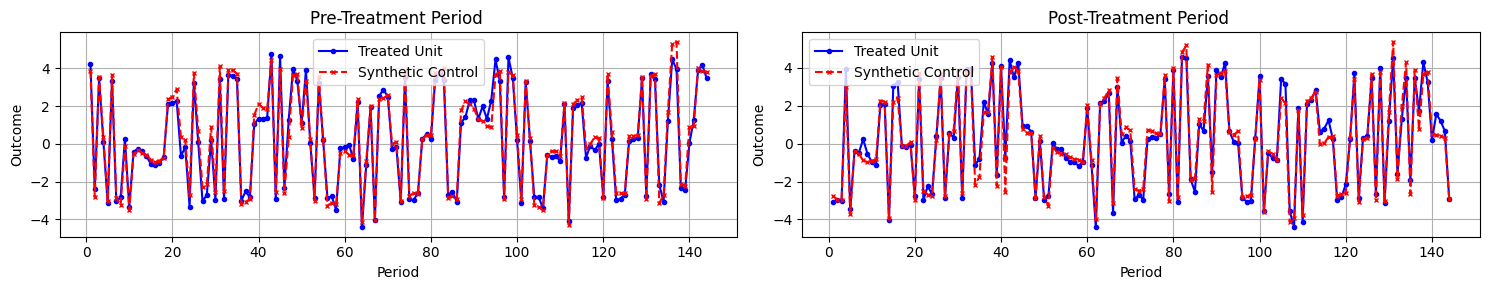

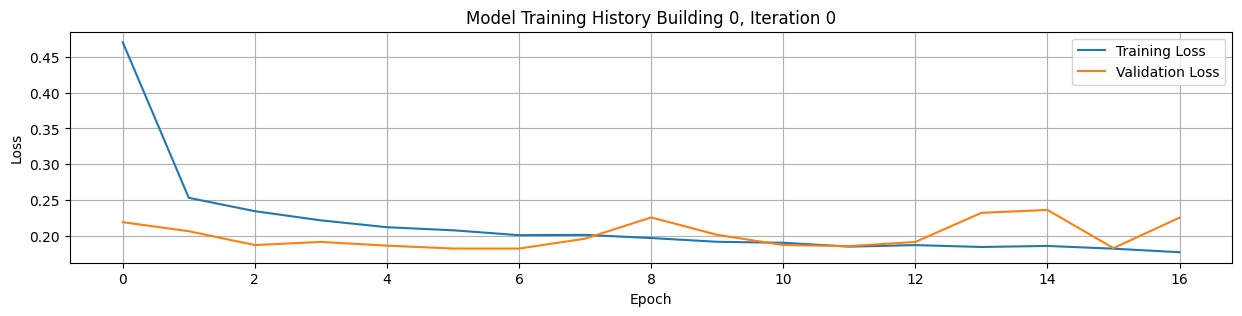

KeyboardInterrupt: 

In [3]:
config = {
    'data_path': '../../data/Energy_dataset_bessScaled.csv',
    'buildings_range': range(1),
    'pre_split': 0.7,
    'shift': 1, # [0,1,2] Best 0
    
    'save_path': None, #"results/nn/",
    'visualize': True,
    'plot_training_history': True,
    'periods_to_plot': 3*48,

    'preselect_donors': False,
    'donor_lookback': 5, # 0 (no lookback), 1, 2, 3, ...
    
    'model_type': 'dense', #['dense', 'lstm']
    'learning_rate': 0.0005, # [0.001 to 0.0001] Best 0.0005
    'batch_size': 32, #[32 to 128] Best 32
    'iterations': 2,
    'epochs': 100, #100
    'validation_split': 0.2,
    'dropout_rate':0.1, #[0.1 to 0.3] Best 0.1
}

sc = SyntheticControlNN()
sc_values, sc_metrics, sc_aggregated_stats = sc.run_sc_nn_multiple_buildings(config)
sc_aggregated_stats